In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from energy_consumption.feature_selection.extract import extract_all_features

## Comparison based on MSPE

In [14]:
energydata_fm = extract_all_features.get_energy_and_features(lasso=True)
energydata_ts = extract_all_features.get_energy_and_features(ts = True)

# make sure both dfs have same length
energydata_ts = energydata_ts.loc[energydata_fm.index[0]:]

did you update weather and index?


In [3]:
energydata_fm

,energy_consumption,winter,spring_autumn,saturday,working_day,period1,period2,period3,period4,period5,period6,holiday,abs_log_ret_weekly,tavg,wspd,tsun,index,population
date_time,,,,,,,,,,,,,,,,,,
2016-12-28 00:00:00,45.54875,1,0,0,1,0,0,0,0,0,0,0,0.083182,4.1,18.7,48.0,89.200000,82.350
2016-12-28 01:00:00,43.06450,1,0,0,1,0,1,0,0,0,0,0,0.083182,4.1,18.7,48.0,89.200000,82.350
2016-12-28 02:00:00,41.96000,1,0,0,1,0,1,0,0,0,0,0,0.083182,4.1,18.7,48.0,89.200000,82.350
2016-12-28 03:00:00,41.95750,1,0,0,1,0,1,0,0,0,0,0,0.083182,4.1,18.7,48.0,89.200000,82.350
2016-12-28 04:00:00,43.31375,1,0,0,1,0,1,0,0,0,0,0,0.083182,4.1,18.7,48.0,89.200000,82.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 08:00:00,65.75125,0,1,0,1,0,0,1,0,0,0,0,0.311336,-1.2,11.2,NaN,79.457567,84.581
2023-11-22 09:00:00,67.40950,0,1,0,1,0,0,0,0,0,0,0,0.311336,-1.2,11.2,NaN,79.457567,84.581
2023-11-22 10:00:00,68.26775,0,1,0,1,0,0,0,0,0,1,0,0.311336,-1.2,11.2,NaN,79.457567,84.581


### QuantReg Model for Energy Data based on its Time Series

Adjust length of training data set for final model, 
* shrunkate data set on upper front for different predictions
* take small intervals to get more precice results

In [17]:
length_adjuster = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 
                   0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 
                   0.3, 0.25, 0.2, 0.16, 0.1, 0.05]
max_length = len(energydata_ts)
mspes = {}

for l in length_adjuster: 

    energydata_temp = energydata_ts[:int(l*max_length)]

    X = energydata_temp.drop(columns=['energy_consumption'])
    y = energydata_temp['energy_consumption']

    # no shuffle --> time series
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.05, shuffle=False)
    
    # add constants
    X_train = sm.add_constant(X_train)
    X_test.insert(loc=0, column='constant', value=1)

    # Initialize QuantReg model 
    quantreg_model = sm.QuantReg(y_train, X_train)

    # Fit the initial model
    quantreg_results = quantreg_model.fit()

    # predict 
    y_pred = quantreg_results.predict(X_test)

    mspe_ts = mean_squared_error(y_test, y_pred)
    print('----------l = ', l, '-----------')
    print("MSPE on Test Set:", mspe_ts)
    mspes.update({l: mspe_ts})

----------l =  1 -----------
MSPE on Test Set: 25.33235427814565
----------l =  0.95 -----------
MSPE on Test Set: 35.324528854225925
----------l =  0.9 -----------
MSPE on Test Set: 41.34129039894503
----------l =  0.85 -----------
MSPE on Test Set: 27.75459170745743
----------l =  0.8 -----------
MSPE on Test Set: 15.65545517703802
----------l =  0.75 -----------
MSPE on Test Set: 22.39724697606716
----------l =  0.7 -----------
MSPE on Test Set: 13.519450507709555
----------l =  0.65 -----------
MSPE on Test Set: 13.387812184649295
----------l =  0.6 -----------
MSPE on Test Set: 30.00985207123193
----------l =  0.55 -----------
MSPE on Test Set: 15.479322914748725
----------l =  0.5 -----------
MSPE on Test Set: 44.918419522386465
----------l =  0.45 -----------
MSPE on Test Set: 33.682594702799236
----------l =  0.4 -----------
MSPE on Test Set: 12.331162003608455
----------l =  0.35 -----------
MSPE on Test Set: 18.037751344604317
----------l =  0.3 -----------
MSPE on Test Set: 

In [20]:
opt_num_obs = int(0.25*max_length)
opt_rmse = mspes[0.25]

([<matplotlib.axis.XTick at 0x296eee69090>,
 [Text(0.1, 0, '6049'),
  Text(0.3, 0, '18148'),
  Text(0.5, 0, '30246'),
  Text(0.7, 0, '42345'),
  Text(0.9, 0, '54444')])

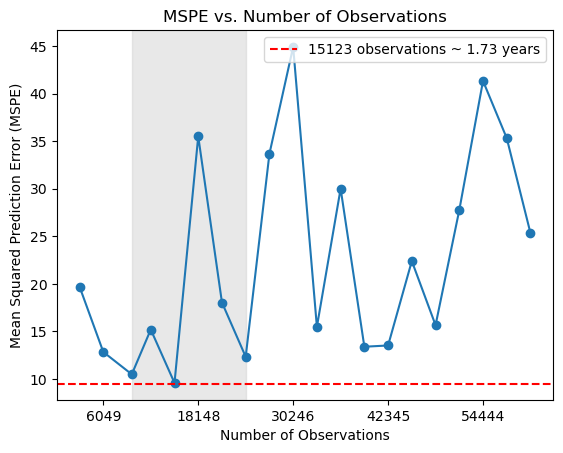

In [21]:
# Extract keys and values from the dictionary
lengths = list(mspes.keys())
mse_values = list(mspes.values())

# Plot the MSEs
plt.plot(lengths, mse_values, marker='o')
plt.title('MSPE vs. Number of Observations')
plt.xlabel('Number of Observations')
plt.ylabel('Mean Squared Prediction Error (MSPE)')
plt.axvspan(0.16,0.4, color='lightgrey', alpha=0.5)

plt.axhline(y=9.51, color='red', linestyle='--',
            label='15123 observations ~ 1.73 years')
plt.legend(loc='upper right')

xticks = [0.1 * 60493, 0.3 * 60493, 0.5 * 60493, 0.7 * 60493, 0.9 * 60493]
plt.xticks(ticks = [0.1, 0.3, 0.5, 0.7, 0.9], labels=[f'{val:.0f}' for val in xticks])

In [10]:
max_length = 15123

In [24]:
energydata_comp = energydata_ts[-opt_num_obs:]

X = energydata_comp.drop(columns=['energy_consumption'])
y = energydata_comp['energy_consumption']

# no shuffle --> time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False)
    
# add constants
X_train = sm.add_constant(X_train)
X_test.insert(loc=0, column='constant', value=1)

# Initialize QuantReg model 
quantreg_model = sm.QuantReg(y_train, X_train)

# Fit the initial model
quantreg_results = quantreg_model.fit()

# predict 
y_pred = quantreg_results.predict(X_test)

mspe_ts = mean_squared_error(y_test, y_pred)
mspe_all = {'QuantReg based on time series': mspe_ts}

### QuantReg Model for EnergyData based on Features

In [25]:
# contuniue with optimal length
energydata_fm = energydata_fm[-opt_num_obs:]

X = energydata_fm.drop(columns=['energy_consumption'])
y = energydata_fm['energy_consumption']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False)

# Initialize QuantReg model
quantreg_model = sm.QuantReg(y_train, sm.add_constant(X_train))

# Fit the initial model
quantreg_results = quantreg_model.fit()

# Define a function to perform RFE using QuantReg
def recursive_feature_elimination(model, X, y, n_features_to_select):
    selected_features = list(X.columns)
    while len(selected_features) > n_features_to_select:
        model = sm.QuantReg(y, sm.add_constant(X[selected_features]))
        results = model.fit()
        p_values = results.pvalues[1:]
        worst_feature = p_values.idxmax()
        selected_features.remove(worst_feature)
    return selected_features

# Set the number of features you want to select
n_features_to_select = [1, 2, 3, 5, 6, 7, 8,
                        9, 10, 11, 12, 13, 14, 
                        15, 16, 17, 18]
mspes_fs = {}

for n in n_features_to_select:
    # Perform RFE using QuantReg
    selected_features_rfe = recursive_feature_elimination(
        quantreg_model, X_train, y_train, n)

    # Train the final model using the selected features
    final_quantreg_model = sm.QuantReg(
        y_train, sm.add_constant(X_train[selected_features_rfe]))
    final_quantreg_results = final_quantreg_model.fit()

    X_test_temp = X_test[selected_features_rfe]
    X_test_temp.insert(loc=0, column='constant', value=1)
    # Make predictions on the test set
    y_pred = final_quantreg_results.predict(X_test_temp)

    # Evaluate the model
    mspe = mean_squared_error(y_test, y_pred)
    print('----------n = ', n, '-----------')
    print("Mean Squared Error on Test Set:", mspe)
    print('Selected_features: ', selected_features_rfe)
    mspes_fs.update({n: mspe})

c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  1 -----------
Mean Squared Error on Test Set: 81.02341615706342
Selected_features:  ['period6']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  2 -----------
Mean Squared Error on Test Set: 64.00245437061889
Selected_features:  ['period3', 'period6']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  3 -----------
Mean Squared Error on Test Set: 48.72307288265738
Selected_features:  ['period2', 'period3', 'period6']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  5 -----------
Mean Squared Error on Test Set: 23.956568682923642
Selected_features:  ['tavg', 'working_day', 'period2', 'period3', 'period6']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  6 -----------
Mean Squared Error on Test Set: 23.67657948497723
Selected_features:  ['tavg', 'working_day', 'period2', 'period3', 'period6', 'holiday']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  7 -----------
Mean Squared Error on Test Set: 20.918180658031222
Selected_features:  ['tavg', 'working_day', 'period1', 'period2', 'period3', 'period6', 'holiday']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  8 -----------
Mean Squared Error on Test Set: 18.960767465454236
Selected_features:  ['tavg', 'working_day', 'period1', 'period2', 'period3', 'period5', 'period6', 'holiday']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  9 -----------
Mean Squared Error on Test Set: 23.633262563617777
Selected_features:  ['tavg', 'working_day', 'period1', 'period2', 'period3', 'period5', 'period6', 'holiday', 'index']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  10 -----------
Mean Squared Error on Test Set: 24.45000325924111
Selected_features:  ['tavg', 'working_day', 'period1', 'period2', 'period3', 'period4', 'period5', 'period6', 'holiday', 'index']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  11 -----------
Mean Squared Error on Test Set: 33.68893184935105
Selected_features:  ['tavg', 'winter', 'working_day', 'period1', 'period2', 'period3', 'period4', 'period5', 'period6', 'holiday', 'index']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  12 -----------
Mean Squared Error on Test Set: 25.340829378333225
Selected_features:  ['tavg', 'sun_hours', 'winter', 'working_day', 'period1', 'period2', 'period3', 'period4', 'period5', 'period6', 'holiday', 'index']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  13 -----------
Mean Squared Error on Test Set: 25.09341626499816
Selected_features:  ['tavg', 'sun_hours', 'winter', 'saturday', 'working_day', 'period1', 'period2', 'period3', 'period4', 'period5', 'period6', 'holiday', 'index']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  14 -----------
Mean Squared Error on Test Set: 23.04776556376275
Selected_features:  ['tavg', 'wspd', 'sun_hours', 'winter', 'saturday', 'working_day', 'period1', 'period2', 'period3', 'period4', 'period5', 'period6', 'holiday', 'index']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  15 -----------
Mean Squared Error on Test Set: 24.126587571249786
Selected_features:  ['tavg', 'wspd', 'sun_hours', 'winter', 'saturday', 'working_day', 'period1', 'period2', 'period3', 'period4', 'period5', 'period6', 'holiday', 'index', 'population']


c:\Users\Maria\Documents\Setups\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


----------n =  16 -----------
Mean Squared Error on Test Set: 25.6235588394366
Selected_features:  ['tavg', 'wspd', 'sun_hours', 'winter', 'spring_autumn', 'saturday', 'working_day', 'period1', 'period2', 'period3', 'period4', 'period5', 'period6', 'holiday', 'index', 'population']
----------n =  17 -----------
Mean Squared Error on Test Set: 25.549452437027885
Selected_features:  ['tavg', 'wspd', 'sun_hours', 'winter', 'spring_autumn', 'saturday', 'working_day', 'period1', 'period2', 'period3', 'period4', 'period5', 'period6', 'holiday', 'abs_log_ret_weekly', 'index', 'population']
----------n =  18 -----------
Mean Squared Error on Test Set: 25.549452437027885
Selected_features:  ['tavg', 'wspd', 'sun_hours', 'winter', 'spring_autumn', 'saturday', 'working_day', 'period1', 'period2', 'period3', 'period4', 'period5', 'period6', 'holiday', 'abs_log_ret_weekly', 'index', 'population']


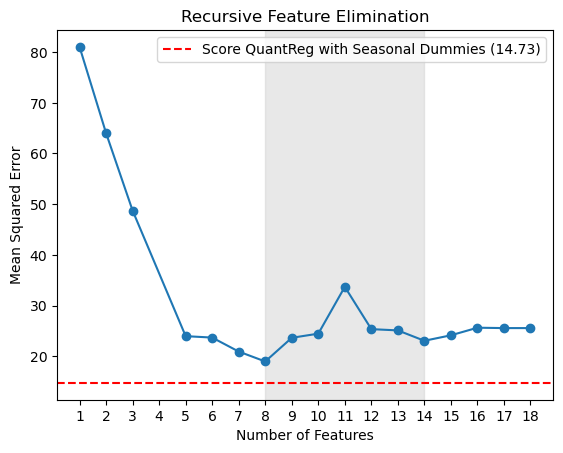

In [26]:
import matplotlib.pyplot as plt

# Extract keys and values from the dictionary
n_features = list(mspes_fs.keys())
mspe_values = list(mspes_fs.values())

# Plot the MSEs
plt.plot(n_features, mspe_values, marker='o')
plt.title('Recursive Feature Elimination')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error')
plt.axvspan(8, 14, color='lightgrey', alpha=0.5)
plt.xticks(range(min(n_features), max(n_features) + 1))

# Add a horizontal line for the specific MSE value
plt.axhline(y=mspe_ts, color='red', linestyle='--',
            label=f'Score QuantReg with Seasonal Dummies ({mspe_ts:.2f})')

# Display legend
plt.legend()

In [27]:
mspe_all.update({'QuantReg based on clustered TS and tavg (n=8)': 18.9607,
                 'QuantReg based on clustered TS and tavg, wspd, index and sun_hours (n=12)': 23.0478})

Interpretation: 
* kommt nicht an TS-Modell dran
* Für n = 8 wird noch 'tavg' hinzugefügt (außer TS Dummies)
* mit n = 14 verringert sich Vorhersageunsicherheit (nahezu eine Linie), hier werden noch 'sun_hours', 'wspd' und 'index' hinzugefügt 

Fazit:
* Versuche, Finales Modell mit TS-Model, ergänzt um die drei Variablen zu generieren
* nutze es, falls MSPE am kleinsten 


Try to merge both data since features are not enough

In [28]:
energydata_advanced = extract_all_features.get_energy_and_features(
    quantReg_advanced=True)[-15123:]
X = energydata_advanced.drop(columns=['energy_consumption'])
y = energydata_advanced['energy_consumption']

# no shuffle --> time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False)

# add constants
X_train = sm.add_constant(X_train)
X_test.insert(loc=0, column='constant', value=1)

# Initialize QuantReg model
quantreg_model = sm.QuantReg(y_train, X_train)

# Fit the initial model
quantreg_results = quantreg_model.fit()

# predict
y_pred = quantreg_results.predict(X_test)

mspe_ts = mean_squared_error(y_test, y_pred)

mspe_all.update({'QuantReg based time series and all features': 17.1046})

did you update weather and index?


{'QuantReg based on time series': 14.73056340597483,
 'QuantReg based on clustered TS and tavg (n=8)': 18.9607,
 'QuantReg based on clustered TS and tavg, wspd, index and sun_hours (n=12)': 23.0478,
 'QuantReg based time series and all features': 17.1046}

In [14]:
energydata_final = extract_all_features.get_energy_and_features(
    quantReg_final=True)[-15123:]
X = energydata_final.drop(columns=['energy_consumption'])
y = energydata_final['energy_consumption']

# no shuffle --> time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, shuffle=False)

# add constants
X_train = sm.add_constant(X_train)
X_test.insert(loc=0, column='constant', value=1)

# Initialize QuantReg model
quantreg_model = sm.QuantReg(y_train, X_train)

# Fit the initial model
quantreg_results = quantreg_model.fit()

# predict
y_pred = quantreg_results.predict(X_test)

mspe_ts = mean_squared_error(y_test, y_pred)
mspe_ts

#mspe_all.update({'QuantReg based time series and tavg': 12.1411})

did you update weather?


12.157213161038179

Kleinster MSPE! 
--> Nur sun_hours weil kein zusätzliches rauschen und hohe Korrelation zu tavg
--> Index erhöht MSPE, deshalb raus 

{'QuantReg based on time series': 14.73056340597483,
 'QuantReg based on clustered TS and tavg (n=8)': 18.9607,
 'QuantReg based on clustered TS and tavg, wspd, index and sun_hours (n=12)': 23.0478,
 'QuantReg based time series and all features': 17.1046,
 'QuantReg based time series and tavg': 12.1572}

In [21]:
import ephem
def calculate_sun_hours(date):
    observer = ephem.Observer()
    observer.lat = str(50.1109)
    observer.lon = str(8.6821)
    observer.date = date

    sunrise = observer.previous_rising(ephem.Sun()).datetime()
    sunset = observer.next_setting(ephem.Sun()).datetime()

    print(sunset-sunrise)
    print(type(sunset-sunrise))

    # Calculate the duration between sunrise and sunset
    sun_hours = (sunset - sunrise).seconds/(60*60)

    return sun_hours


calculate_sun_hours('2024-01-10')

1 day, 8:22:04.991211
<class 'datetime.timedelta'>


8.367777777777778